# End-To-End Train and Deploy Machine Learning Model on Kubernetes

Using:

 * kubeflow
 * seldon-core
 
 
Follow the main README to setup, train and deploy your model. This notebook will show how to run the Argo jobs and example prediction calls to the deployed models.

**To run this notebook you will need to install Tensorflow**
 
The example will be the MNIST handwriiten digit classification task.

![MNIST](mnist.png "MNIST Digits")

## 5. Data Science
You will need Tensorflow installed to run this section.

In [37]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def gen_image(arr):
    two_d = (np.reshape(arr, (28, 28)) * 255).astype(np.uint8)
    plt.imshow(two_d,cmap=plt.cm.gray_r, interpolation='nearest')
    return plt

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


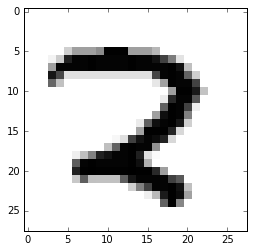

In [38]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_xs, batch_ys = mnist.train.next_batch(10)
gen_image(batch_xs[1]).show()

In [39]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

x = tf.placeholder(tf.float32, [None,784], name="x")
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0.9168


# Dockerize and Train Model
You can skip this if you have done this already following the README.

In [25]:
!argo submit ../workflows/training-tf-mnist-workflow.yaml

Name:             kubeflow-train-2x2pq
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Fri Feb 09 15:37:30 +0000 (1 second ago)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio
  tfjob-version-hack: 1


Wait until the Argo job is completed

In [26]:
!argo list

NAME                   STATUS    AGE    DURATION
kubeflow-train-2x2pq   Running   15s    15s 


You can get more info on your job by using Argo get, but you will need to change the job id

In [30]:
!argo get kubeflow-train-2x2pq

Name:             kubeflow-train-2x2pq
Namespace:        default
ServiceAccount:   default
Status:           Succeeded
Created:          Fri Feb 09 15:37:30 +0000 (3 minutes ago)
Started:          Fri Feb 09 15:37:30 +0000 (3 minutes ago)
Finished:         Fri Feb 09 15:40:54 +0000 (23 seconds ago)
Duration:         3 minutes 24 seconds
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio
  tfjob-version-hack: 1

STEP                     PODNAME                          DURATION  MESSAGE
 ✔ kubeflow-train-2x2pq                                             
 ├---✔ build-push        kubeflow-train-2x2pq-4048894882  1m        
 └---✔ train             kubeflow-train-2x2pq-1479042668  1m        


Delete argo job to free persistent disk usage.

In [ ]:
!argo delete --all

# Dockerize and Deploy Runtime Model
You can skip this if you have followed the README and the deployment is already running.

In [32]:
!argo submit ../workflows/serving-tf-mnist-workflow.yaml

Name:             seldon-package-db5m7
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Fri Feb 09 15:42:12 +0000 (now)
Parameters:       
  version:        0.1


Wait untl Argo job is finished.

In [34]:
!argo list

NAME                   STATUS      AGE   DURATION
seldon-package-db5m7   Running     1m    1m 
kubeflow-train-2x2pq   Succeeded   5m    3m 


## Get predictions
**Ensure you have port forwarded the ambassador reverse proxy**

```bash
kubectl port-forward $(kubectl get pods -n default -l service=ambassador -o jsonpath='{.items[0].metadata.name}') -n default 8002:80
```

If you need to deploy the model again you can directly use the kubernetes manifest for it

In [35]:
!kubectl apply -f ../k8s_serving/serving_model.json

seldondeployment "mnist-classifier" configured


In [27]:
import requests
from requests.auth import HTTPBasicAuth
import commands
from random import randint,random
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
import json
from visualizer import get_graph

#AMBASSADOR_API_IP=commands.getoutput("kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].ip}'")
AMBASSADOR_API_IP="localhost:8002"

def rest_request(deploymentName,request):
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=request)
    return response.json()   
    
def rest_request_auth(deploymentName,data,username,password):
    payload = {"data":{"ndarray":data.tolist()}}
    response = requests.post(
                "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/predictions",
                json=payload,
                auth=HTTPBasicAuth(username, password))
    print response.status_code
    return response.json()   

def grpc_request(deploymentName,data):
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [1,784],
                values = data
                )
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(AMBASSADOR_API_IP)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('seldon',deploymentName)]
    response = stub.Predict(request=request,metadata=metadata)
    print response

def send_feedback_rest(deploymentName,request,response,reward):
    feedback = {
        "request": request,
        "response": response,
        "reward": reward
    }
    ret = requests.post(
         "http://"+AMBASSADOR_API_IP+"/seldon/"+deploymentName+"/api/v0.1/feedback",
        json=feedback)
    return ret.text


#### REST Request

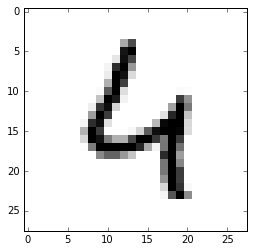

{
  "meta": {
    "puid": "m9l6b7h4d2bkv1q2esc6i6h9ri", 
    "routing": {}, 
    "tags": {}
  }, 
  "data": {
    "names": [
      "class:0", 
      "class:1", 
      "class:2", 
      "class:3", 
      "class:4", 
      "class:5", 
      "class:6", 
      "class:7", 
      "class:8", 
      "class:9"
    ], 
    "ndarray": [
      [
        4.421320045366883e-05, 
        6.564765044458909e-06, 
        0.009412484243512154, 
        1.7505271898698993e-05, 
        0.9371029138565063, 
        0.0004079443751834333, 
        0.018243910744786263, 
        0.0004114382900297642, 
        0.0016936453757807612, 
        0.03265940025448799
      ]
    ]
  }
}


In [40]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((1,784))
request = {"data":{"ndarray":data.tolist()}}
predictions = rest_request("mnist-classifier",request)
print(json.dumps(predictions, indent=2))

gRPC Request

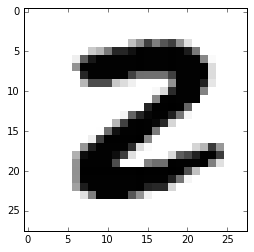

meta {
  puid: "6ahci6c0d6kffroi66scbhpev3"
}
data {
  names: "class:0"
  names: "class:1"
  names: "class:2"
  names: "class:3"
  names: "class:4"
  names: "class:5"
  names: "class:6"
  names: "class:7"
  names: "class:8"
  names: "class:9"
  tensor {
    shape: 1
    shape: 10
    values: 2.36250216403e-05
    values: 7.54742845999e-09
    values: 0.963542997837
    values: 0.00112966191955
    values: 8.49796882169e-12
    values: 7.86082910054e-06
    values: 5.91073785472e-07
    values: 1.81448689407e-10
    values: 0.0352952554822
    values: 4.26933066677e-09
  }
}



In [41]:
batch_xs, batch_ys = mnist.train.next_batch(1)
chosen=0
gen_image(batch_xs[chosen]).show()
data = batch_xs[chosen].reshape((784))
grpc_request("mnist-classifier",data)

# Next Steps
seldon-core can deploy complex runtime graphs. We'll illustrate two below by training a second model using scikit-learn.

In [15]:
!argo submit ../workflows/training-sk-mnist-workflow.yaml

Name:             kubeflow-train-hxvmc
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Tue Feb 13 18:23:44 +0000 (1 second ago)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio


In [13]:
!argo list

NAME                   STATUS      AGE   DURATION
kubeflow-train-5jpkn   Failed      4m    2m 
seldon-deploy-ckczd    Succeeded   1d    3m 


In [16]:
!argo submit ../workflows/serving-sk-mnist-workflow.yaml

Name:             seldon-deploy-xh84k
Namespace:        default
ServiceAccount:   default
Status:           Pending
Created:          Tue Feb 13 18:32:04 +0000 (now)
Parameters:       
  version:        0.1
  github-user:    SeldonIO
  docker-user:    seldonio


In [17]:
!argo list

NAME                   STATUS      AGE    DURATION
seldon-deploy-xh84k    Running     15s    15s 
kubeflow-train-hxvmc   Succeeded   8m     3m 


## AB Test
 Run an AB Test between Tensorflow model and SKLearn Random Forest.
 

In [42]:
!pygmentize ../k8s_serving/ab_test_sklearn_tensorflow.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

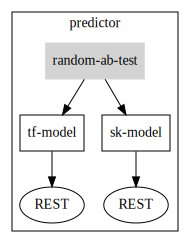

In [43]:
get_graph("../k8s_serving/ab_test_sklearn_tensorflow.json",'r')

In [20]:
!kubectl apply -f ../k8s_serving/ab_test_sklearn_tensorflow.json

seldondeployment "mnist-classifier" configured


Wait until ready (replicas == replicasAvailable)

In [21]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100


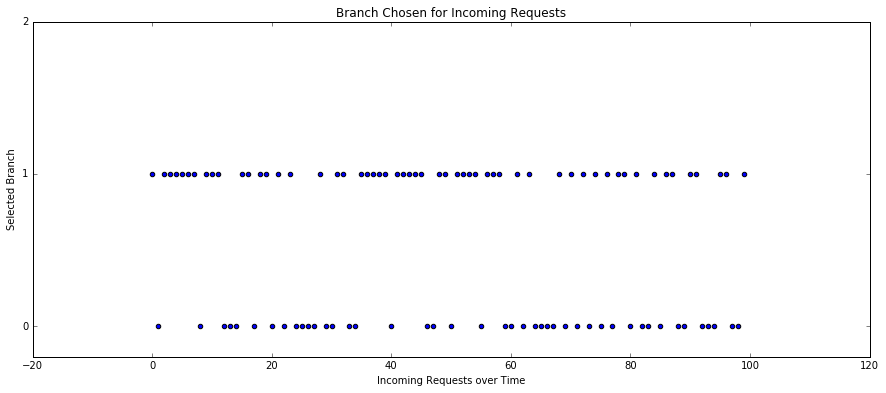

In [22]:
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print "{}/{}".format(idx,sz)
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("random-ab-test")
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")

## Multi-Armed Bandit
Run a e-greey multi-armed bandit to push traffic to best performing model.

In [30]:
!pygmentize ../k8s_serving/epsilon_greedy.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha1",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "mnist-classifier"
    },
    "spec": {
	"annotations": {
	    "project_name": "kubeflow-seldon",
	    "deployment_version": "v1"
	},
	"name": "mnist-classifier",
	"predictors": [
	    {
		"componentSpec": {
		    "spec": {
			"containers": [
			    {
                                "image": "seldonio/deepmnistclassifier_runtime:0.1",
				"name": "tf-model",
                                "volumeMounts": [
                                    {
                                        "mountPath": "/data",
                                        "name": "persistent-storage"
                                    }
                                ]
			    },
			    {
                                "image": "seldonio/skmnistclassifier_runtime:0.1",
				"name": "sk-model",
                                "volumeMounts": [
                 

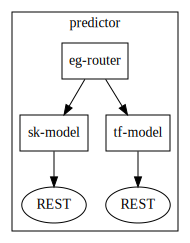

In [31]:
get_graph("../k8s_serving/epsilon_greedy.json",'r')

In [32]:
!kubectl apply -f ../k8s_serving/epsilon_greedy.json

seldondeployment "mnist-classifier" configured


Wait until ready (replicas == replicasAvailable)

In [33]:
!kubectl get seldondeployments mnist-classifier -o jsonpath='{.status}'

map[predictorStatus:[map[name:mnist-classifier-mnist-classifier replicas:1 replicasAvailable:1]]]

0/100
10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
[3.0, 80.0]


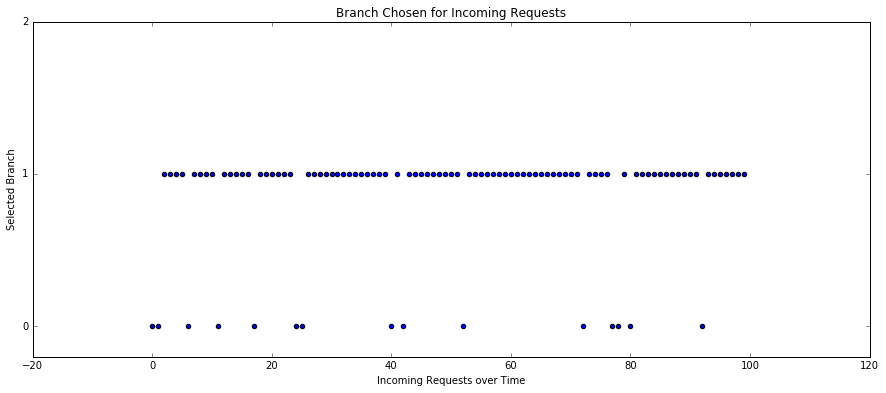

In [34]:
score = [0.0,0.0]
sz = 100
batch_xs, batch_ys = mnist.train.next_batch(sz)
routes_history = []
for idx in range(sz):
    if idx % 10 == 0:
        print "{}/{}".format(idx,sz)
    data = batch_xs[idx].reshape((1,784))
    request = {"data":{"ndarray":data.tolist()}}
    response = rest_request("mnist-classifier",request)
    route = response.get("meta").get("routing").get("eg-router")
    proba = response["data"]["ndarray"][0]
    predicted = proba.index(max(proba))
    correct = np.argmax(batch_ys[idx])
    if predicted == correct:
        score[route] = score[route] + 1
        send_feedback_rest("mnist-classifier",request,response,reward=1)
    else:
        send_feedback_rest("mnist-classifier",request,response,reward=0)
    routes_history.append(route)

plt.figure(figsize=(15,6))
ax = plt.scatter(range(len(routes_history)),routes_history)
ax.axes.xaxis.set_label_text("Incoming Requests over Time")
ax.axes.yaxis.set_label_text("Selected Branch")
plt.yticks([0,1,2])
_ = plt.title("Branch Chosen for Incoming Requests")
print score